<a href="https://colab.research.google.com/github/XiangxiangXu/NFL/blob/main/f_orth_cosine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set GPU.

In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
import torch

In [ ]:
import numpy as np
from scipy.stats import cosine


def modshift(t):
    # shift t to interval [-1, 1] by some 2 * n
    return np.divmod(t + 1, 2)[1] - 1



In [ ]:
# number of samples
nSamples_train = 50000
nSamples_test = 10000
nSamples = nSamples_train + nSamples_test


## Parameters for Training
# batch size
batchsize = 256

# number of epochs
nEpochs = 100

dim = 2

In [ ]:

X = 2 * np.random.rand(nSamples) - 1  # x ~ Unif[-1, 1]
Y = modshift(X + cosine.rvs(size=(nSamples)) / np.pi)

(array([1962., 2075., 1999., 2038., 1922., 2017., 2008., 1989., 2026.,
        2066., 2057., 2019., 2087., 1955., 2068., 1976., 1984., 2039.,
        1978., 2004., 1935., 1959., 1910., 2009., 2049., 2004., 1974.,
        2028., 1948., 1915.]),
 array([-9.99973428e-01, -9.33308486e-01, -8.66643543e-01, -7.99978600e-01,
        -7.33313657e-01, -6.66648715e-01, -5.99983772e-01, -5.33318829e-01,
        -4.66653886e-01, -3.99988944e-01, -3.33324001e-01, -2.66659058e-01,
        -1.99994115e-01, -1.33329173e-01, -6.66642300e-02,  7.12764125e-07,
         6.66656555e-02,  1.33330598e-01,  1.99995541e-01,  2.66660484e-01,
         3.33325427e-01,  3.99990369e-01,  4.66655312e-01,  5.33320255e-01,
         5.99985198e-01,  6.66650140e-01,  7.33315083e-01,  7.99980026e-01,
         8.66644969e-01,  9.33309911e-01,  9.99974854e-01]),
 <BarContainer object of 30 artists>)

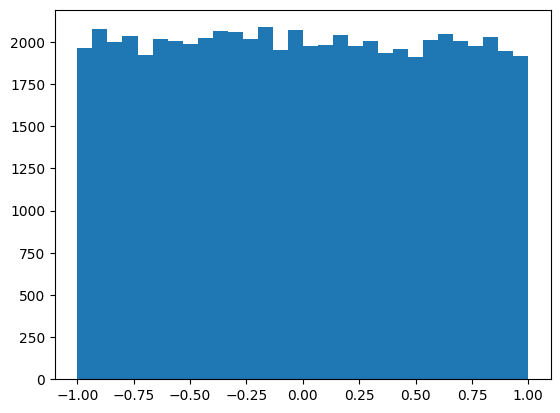

In [ ]:
from matplotlib import pyplot as plt
plt.hist(X, 30)

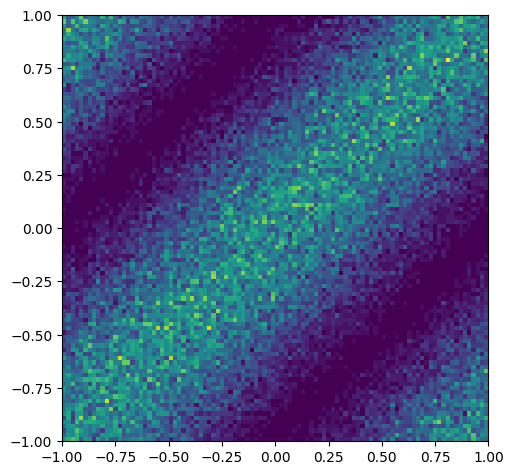

In [ ]:
plt.hist2d(X, Y, 100)

plt.tight_layout()
plt.axis([-1, 1, -1, 1])
plt.gca().set_aspect('equal', adjustable='box')#plt.axis('equal')

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
Xt = torch.tensor(X, dtype=torch.float32)
Yt = torch.tensor(Y, dtype=torch.float32)
# dataloder for training
Xt_train = Xt[:nSamples_train]
Yt_train = Yt[:nSamples_train]

ds = TensorDataset(Xt_train, Yt_train)
dl = DataLoader(ds, batch_size=batchsize, shuffle = True)

# test data
X_test = X[nSamples_train:]
Y_test = Y[nSamples_train:]

Xt_test = Xt[nSamples_train:]
Yt_test = Yt[nSamples_train:]

In [ ]:
from torch import nn, optim
import torch.nn.functional as F
class mlp(nn.Module):
    def __init__(self, dim_list, activation = F.relu):
        super().__init__()
        self.fc_list = nn.ModuleList([nn.Linear(dim_list[i], dim_list[i+1]) for i in range(len(dim_list) - 1)])
        self.activation = activation

    def forward(self, x):
        num_layers = len(self.fc_list)
        for i in range(num_layers):
            x = self.fc_list[i](x)
            if i != num_layers - 1: # activate except for the last layer
                x = self.activation(x)
        return x

class mlp_parallel(nn.Module):
    def __init__(self, dim_list, m = 1, activation = F.relu):
        super().__init__()
        self.mlp_list = nn.ModuleList([mlp(dim_list, activation) for i in range(m)])

    def forward(self, x):
        f = torch.cat([mlp_(x) for mlp_ in self.mlp_list], axis = -1)
        return f

class fg_nn(nn.Module): # f_net, g_net
    def __init__(self, f_net, g_net):
        super().__init__()
        self.f_net = f_net
        self.g_net = g_net

    def forward(self, x, y):
        f = self.f_net(x)
        g = self.g_net(y)
        return f, g

    def get_f(self, x):
        f = self.f_net(x)
        return f

    def get_g(self, y):
        g = self.g_net(y)
        return g

f_net = mlp([1, 32, 32, dim], activation = F.softplus) # mlp_parallel([1, 32, 32, 1], m = dim, activation = F.softplus) #
g_net = mlp([1, 32, 32, dim], activation = F.softplus) # mlp_parallel([1, 32, 32, 1], m = dim, activation = F.softplus)

model = fg_nn(f_net, g_net)
# model.to(device)
opt = optim.Adam(model.parameters()) # optim.RMSprop(model.parameters(), lr = 1e-3) # or Adam

In [ ]:
centralize = lambda x: x - torch.mean(x, 0) # zero-mean
cov = lambda x: x.T @ x / (x.size()[0]-1.) # covariance

def neg_hscore(f, g):
    """
    compute the negative h-score
    """
    f0 = centralize(f)
    g0 = centralize(g)
    corr = torch.mean(torch.sum(f0*g0, 1))
    # to generate zero-mean f, g
    cov_f = cov(f)
    cov_g = cov(g)
    return - corr + torch.trace(cov_f @ cov_g) / 2.

def neg_hscore_nest(f, g, dim0 = 0):
    """
    compute the (nagative) nested H-score:

    from dim0
    """
    f_dim = f.shape[1]
    neg_h_nest = torch.sum(torch.stack(
        [neg_hscore(f[:, :i+1], g[:, :i+1])
         for i in range(dim0, f_dim)]))
    return neg_h_nest

In [ ]:
for epoch in range(nEpochs):
    for x, y in dl:
        f_, g_ = model(x.reshape(-1, 1), y.reshape(-1, 1))
        loss = neg_hscore_nest(f_, g_)
        loss.backward()
        opt.step()
        opt.zero_grad()
    if epoch % 10 == 0:
        print('epoch:', epoch, '/', nEpochs)# 'training neg_h_score =', loss)


epoch: 0 / 100
epoch: 10 / 100
epoch: 20 / 100
epoch: 30 / 100
epoch: 40 / 100
epoch: 50 / 100
epoch: 60 / 100
epoch: 70 / 100
epoch: 80 / 100
epoch: 90 / 100


In [ ]:
detach = lambda x: x.cpu().detach().numpy()
norm = lambda x: np.sqrt(np.mean(x**2))

# get features on the training set
f_train = detach(model.get_f(Xt_train.reshape(-1, 1)))
g_train = detach(model.get_g(Yt_train.reshape(-1, 1)))

# compute norm for each dimension
norm_f = np.zeros(dim)
norm_g = np.zeros(dim)
#mu_f = np.zeros(dim)
#mu_g = np.zeros(dim)
for i in range(dim):
    #mu_f[i] = np.mean(f_train[:, i])
    norm_f[i] = norm(f_train[:, i])
    #mu_g[i] = np.mean(g_test[:, i])
    norm_g[i] = norm(g_train[:, i])

Xt_grid = torch.linspace(-1, 1, steps=1000).reshape(-1, 1)
X_grid = detach(Xt_grid).reshape(-1)
Yt_grid = Xt_grid
Y_grid = X_grid

f_grid = detach(model.get_f(Xt_grid))
g_grid = detach(model.get_g(Yt_grid))





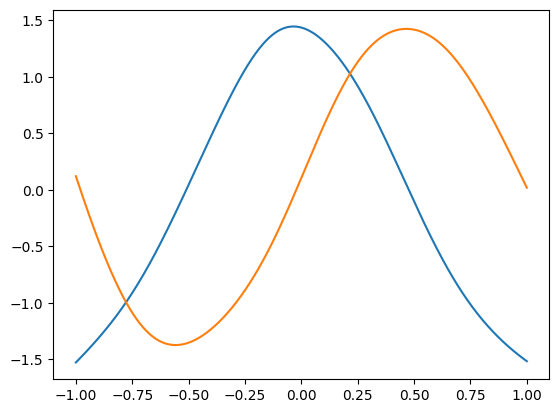

In [ ]:
# normalize ...
plt.plot(X_grid, f_grid[:, 0]/norm_f[0])
plt.plot(X_grid, f_grid[:, 1]/norm_f[1])

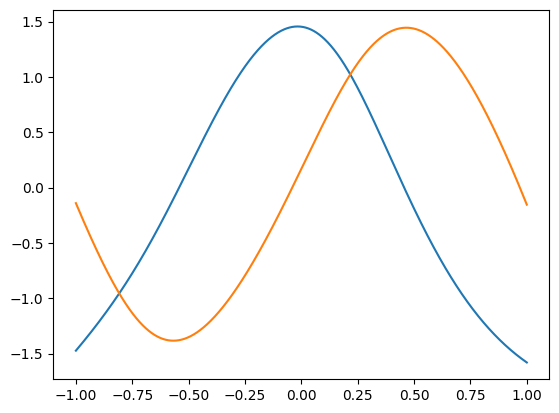

In [ ]:
# normalize ...
plt.plot(Y_grid, g_grid[:, 0]/norm_g[0])
plt.plot(Y_grid, g_grid[:, 1]/norm_g[1])

In [ ]:
# get features on the testing set
f_test = model.get_f(Xt_test.reshape(-1, 1)).detach().numpy()
g_test = model.get_g(Yt_test.reshape(-1, 1)).detach().numpy()

# # compute stand deviations for each dimension
# std_f = np.zeros(dim)
# std_g = np.zeros(dim)
# mu_f = np.zeros(dim)
# mu_g = np.zeros(dim)
# for i in range(dim):
#     mu_f[i] = np.mean(f_test[:, i])
#     std_f[i] = np.std(f_test[:, i])
#     mu_g[i] = np.mean(g_test[:, i])
#     std_g[i] = np.std(g_test[:, i])

Compute Correlation

In [ ]:
# compute the correlation coefficients between x, y
corr = lambda x, y: (np.corrcoef(x.reshape(-1), y.reshape(-1)))[0, 1]


print('corr(x, y) =', corr(X, Y))
print('corr(f1(x), f2(x)) =', corr(f_test[:, 0], f_test[:, 1]))
print('corr(f1(x), g1(y)) =', corr(f_test[:, 0], g_test[:, 0]))

print('corr(f2(x), g2(y)) =', corr(f_test[:, 1], g_test[:, 1]))


corr(x, y) = 0.303340732767371
corr(f1(x), f2(x)) = -0.0030565727876556313
corr(f1(x), g1(y)) = 0.508917283865397
corr(f2(x), g2(y)) = 0.48851135456136147


In [ ]:

# for i in range(dim):
#     plt.scatter(X_test, f_test[:, i]/std_f[i])
# #plt.scatter(X, f_trained_all[:, 1])
# for i in range(dim):
#     plt.scatter(Y_test, g_test[:, i]/std_g[i])

In [ ]:
# for i in range(dim):
#     plt.scatter(X_test, np.arccos((f_test[:, i] - mu_f[i])/std_f[i]/np.sqrt(2)))

# for i in range(dim):
#     plt.scatter(Y_test, np.arccos((g_test[:, i] - mu_g[i])/std_g[i]/np.sqrt(2)))

## Estimation of $\psi(Y)$

We consider the estimation of
$\psi_1(y) = y, \psi_2(y) = y^2, \psi_3(y) = \exp(y)$.

In [ ]:

f_t_grid = model.get_f(Xt_grid)#.detach().numpy()
#Yt_grid = torch.linspace(-1, 1, steps=1000).reshape(-1, 1)

psi = lambda y: torch.cat([y, y**2, torch.exp(y)], axis = -1)

psi_train = psi(Yt_train.reshape(-1, 1))
g_train = model.get_g(Yt_train.reshape(-1, 1))#.detach().numpy()
La_psi_g = torch.mean(psi_train[:, :, None] * g_train[:, None, :], axis = 0)

psi_mean = psi_train.mean(axis = 0)


psi_est = detach(psi_mean + f_t_grid @ La_psi_g.T)

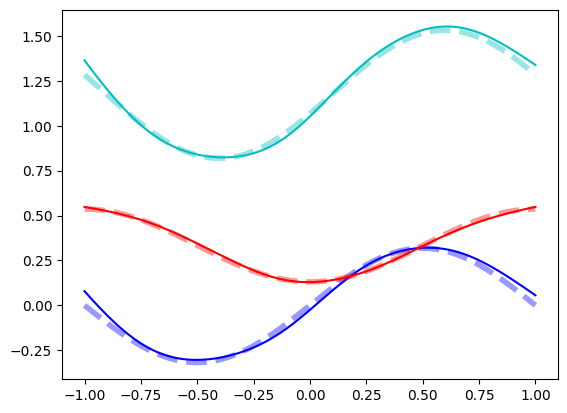

In [ ]:
psi_est_gt = np.zeros(psi_est.shape)
psi_est_gt[:, 0] = np.sin(np.pi * X_grid) / np.pi
psi_est_gt[:, 1] = 1/3 - 2 / (np.pi ** 2) * np.cos(np.pi * X_grid)
psi_est_gt[:, 2] = (np.exp(2) - 1)/(2 * np.exp(1) * (1 + np.pi ** 2)) * (np.pi * np.sin(np.pi * X_grid) - np.cos(np.pi * X_grid) + np.pi**2 + 1)
color = ['b', 'r', 'c']
for i in range(psi_est.shape[1]):
    plt.plot(X_grid, psi_est[:, i], color[i])
    plt.plot(X_grid, psi_est_gt[:, i], color[i] + '--', linewidth = 4, alpha = .4)

## Learning Feature Orthogonal to $\bar{f}$

In [ ]:
# f g module with two parts (fb, gb) & (f, g)
class fg_nn2(nn.Module): # with two parts
    def __init__(self, fb_net, gb_net, f_net, g_net):
        super().__init__()

        self.fb_net = fb_net
        self.gb_net = gb_net
        self.f_net = f_net
        self.g_net = g_net

    def forward(self, x, y):
        fb = self.fb_net(x)
        gb = self.gb_net(y)
        f = self.f_net(x)
        g = self.g_net(y)
        return fb, gb, f, g

    def get_fb(self, x):
        fb = self.fb_net(x)
        return fb

    def get_f(self, x):
        f = self.f_net(x)
        return f

    def get_gb(self, y):
        gb = self.gb_net(y)
        return gb

    def get_g(self, y):
        g = self.g_net(y)
        return g



def neg_hscore2(fb, gb, f, g):
    """
    compute the (nagative) H-score with two parts

    from dim 0
    """
    res = neg_hscore(fb, gb)
    res += neg_hscore(torch.cat([fb, f], axis = 1), torch.cat([gb, g], axis = 1))
    return res

In [ ]:
kb = 1
k = 1

fb_even = lambda x: x**2 # learn feature f orthgonal to x^2

fb_odd = lambda x: x # learn feature f orthgonal to x

gb_net = mlp([1, 32, 32, k], activation = F.softplus)
f_net = mlp([1, 32, 32, k], activation = F.softplus)
g_net = mlp([1, 32, 32, k], activation = F.softplus)

model_orth = fg_nn2(fb_even, gb_net, f_net, g_net)
# model.to(device)
opt_orth = optim.Adam(model_orth.parameters()) # optim.RMSprop(model.parameters(), lr = 1e-3) # or Adam

for epoch in range(nEpochs):
    for x, y in dl:
        fb_, gb_, f_, g_ = model_orth(x.reshape(-1, 1), y.reshape(-1, 1))
        loss = neg_hscore2(fb_, gb_, f_, g_)
        loss.backward()
        opt_orth.step()
        opt_orth.zero_grad()
    if epoch % 10 == 0:
        print('epoch:', epoch+1, '/', nEpochs)# 'training neg_h_score =', loss)

epoch: 1 / 100
epoch: 11 / 100
epoch: 21 / 100
epoch: 31 / 100
epoch: 41 / 100
epoch: 51 / 100
epoch: 61 / 100
epoch: 71 / 100
epoch: 81 / 100
epoch: 91 / 100


In [ ]:
f_grid_orth_even = detach(model_orth.get_f(Xt_grid))
# compute norm
f_train_orth_even = detach(model_orth.get_f(Xt_train.reshape(-1, 1)))
norm_f_orth_even = norm(f_train_orth_even)

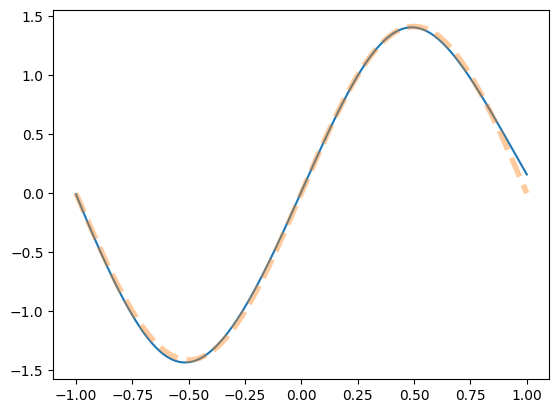

In [ ]:
# plot
f_grid_orth_even_gt = np.sqrt(2) * np.sin(np.pi * X_grid)
f_grid_orth_even_plot = (f_grid_orth_even / norm_f_orth_even).reshape(-1)

f_grid_orth_even_plot *= np.sign(np.sum(f_grid_orth_even_plot * f_grid_orth_even_gt))

plt.plot(X_grid, f_grid_orth_even_plot )
plt.plot(X_grid, f_grid_orth_even_gt, '--',  linewidth = 4, alpha = .4)
#g_test = model_orth.get_g(Yt_test.reshape(-1, 1)).detach().numpy()



In [ ]:
gb_net = mlp([1, 32, 32, k], activation = F.softplus)
f_net = mlp([1, 32, 32, k], activation = F.softplus)
g_net = mlp([1, 32, 32, k], activation = F.softplus)

model_orth = fg_nn2(fb_odd, gb_net, f_net, g_net)
# model.to(device)
opt_orth = optim.Adam(model_orth.parameters()) # optim.RMSprop(model.parameters(), lr = 1e-3) # or Adam

for epoch in range(nEpochs):
    for x, y in dl:
        fb_, gb_, f_, g_ = model_orth(x.reshape(-1, 1), y.reshape(-1, 1))
        loss = neg_hscore2(fb_, gb_, f_, g_)
        loss.backward()
        opt_orth.step()
        opt_orth.zero_grad()
    if epoch % 10 == 0:
        print('epoch:', epoch+1, '/', nEpochs)# 'training neg_h_score =', loss)

epoch: 1 / 100
epoch: 11 / 100
epoch: 21 / 100
epoch: 31 / 100
epoch: 41 / 100
epoch: 51 / 100
epoch: 61 / 100
epoch: 71 / 100
epoch: 81 / 100
epoch: 91 / 100


In [ ]:
f_grid_orth_odd = detach(model_orth.get_f(Xt_grid))

# compute norm
f_train_orth_odd = detach(model_orth.get_f(Xt_train.reshape(-1, 1)))
norm_f_orth_odd = norm(f_train_orth_odd)

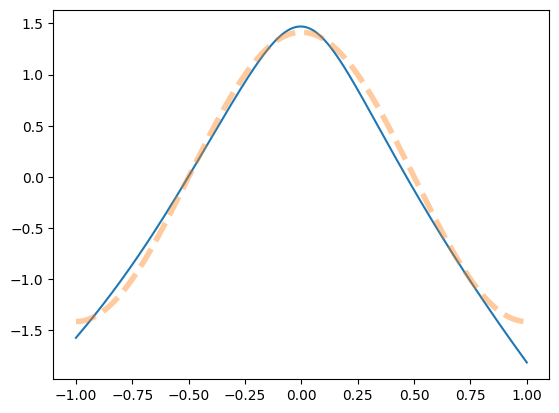

In [ ]:
# plot
f_grid_orth_odd_gt =  np.sqrt(2) * np.cos(np.pi * X_grid)

f_grid_orth_odd_plot = (f_grid_orth_odd / norm_f_orth_odd).reshape(-1)
f_grid_orth_odd_plot *= np.sign(np.sum(f_grid_orth_odd_plot * f_grid_orth_odd_gt))
plt.plot(X_grid, f_grid_orth_odd_plot)
plt.plot(X_grid, f_grid_orth_odd_gt, '--',  linewidth = 4, alpha = .4)
#g_test = model_orth.get_g(Yt_test.reshape(-1, 1)).detach().numpy()


In [ ]:
f_grid_orth_odd_gt.shape # * f_grid_orth_odd_gt

(1000,)

In [ ]:
# np.savez('cosine.npz',
#          X = X,
#          Y = Y,
#          f_grid = f_grid,
#          g_grid = g_grid,
#          X_grid = X_grid,
#          Y_grid = Y_grid,
#          norm_f = norm_f,
#          norm_g = norm_g,
#          psi_est = psi_est,
#          psi_est_gt = psi_est_gt,
#          f_grid_orth_even_plot = f_grid_orth_even_plot,
#          f_grid_orth_even_gt = f_grid_orth_even_gt,
#          f_grid_orth_odd_plot = f_grid_orth_odd_plot,
#          f_grid_orth_odd_gt = f_grid_orth_odd_gt)